In [16]:
import numpy as np
from util import times_to_lags

def preprocess(X, m_max=np.Inf):
    '''
    对time lag只除了标准差
    X[samples : timesteps : dims]
    '''
    X = X.copy()

    X[:, :, 0] = times_to_lags(X[:, :, 0])

    mag_means = np.atleast_2d(np.nanmean(X[:, :, 1], axis=1)).T
    X[:, :, 1] -= mag_means

    mag_scales = np.atleast_2d(np.nanstd(X[:, :, 1], axis=1)).T
    X[:, :, 1] /= mag_scales

    # err_scales = np.atleast_2d(np.nanstd(X[:, :, 2], axis=1)).T
    # X[:, :, 2] /= err_scales

    # lag_means = np.atleast_2d(np.nanmean(X[:, :, 0], axis=1)).T
    # X[:, :, 0] -= mag_means

    lag_scales = np.atleast_2d(np.nanstd(X[:, :, 0], axis=1)).T
    X[:, :, 0] /= lag_scales

    X[np.isnan(X)] = 0

    return X


In [17]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pickle
import numpy as np
f1 = open('data/split_uncertainty_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/train_data0', 'rb')
X_sequence_train, X_feature_train, X_image_train, X_uncertainty_map_train, Y_train = pickle.load(f1)
# X_sequence_train, X_feature_train, Y_train = pickle.load(f1)
f1.close()
f2 = open('data/split_uncertainty_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/val_data', 'rb')
X_sequence_val, X_feature_val, X_image_val, X_uncertainty_map_val, Y_val = pickle.load(f2)
# X_sequence_val, X_feature_val, Y_val = pickle.load(f2)
f2.close()
f3 = open('data/split_uncertainty_image_0.60_0.30_0.10_aug_to_3000_down_sample_True_instance0-9/test_data', 'rb')
X_sequence_test, X_feature_test, X_image_test, X_uncertainty_map_test, Y_test = pickle.load(f3)
# X_sequence_test, X_feature_test,  Y_test = pickle.load(f3)
f3.close()

from keras_preprocessing.sequence import pad_sequences
X_sequence_train_paded = pad_sequences(X_sequence_train, dtype='float', padding='post', value = np.nan)
X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
# 先pad再预处理，因为pad可以把array的list转为ndarray

X_sequence_train_trimed = preprocess(X_sequence_train_paded)
X_sequence_val_trimed = preprocess(X_sequence_val_paded)
X_sequence_test_trimed = preprocess(X_sequence_test_paded)

X_feature_train = np.array(X_feature_train)
X_feature_val = np.array(X_feature_val)
X_feature_test = np.array(X_feature_test)
Y_train = np.array(Y_train)-1 # 文件夹名从1开始但是标签从0开始
Y_val = np.array(Y_val)-1
Y_test = np.array(Y_test)-1



In [18]:
Y_train_one_hot = keras.utils.to_categorical(Y_train, num_classes=11)
Y_val_one_hot = keras.utils.to_categorical(Y_val, num_classes=11)
Y_test_one_hot = keras.utils.to_categorical(Y_test, num_classes=11)

In [19]:
from mix_models import rnn_with_feature


model = rnn_with_feature(sequence_shape=(None, 3),feature_shape=(2,), num_classes=11)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    # loss="sparse_categorical_crossentropy",
    # loss=categorical_focal_loss(alpha=np.ones(11)),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    # metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    run_eagerly=False,
)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath='models/rnn_with_feature_test/model_{epoch}',
    save_freq='epoch'),
  keras.callbacks.TensorBoard(log_dir='models/rnn_with_feature_test/logs')
]

In [20]:
X_train = {'sequence':X_sequence_train_trimed,  'feature':X_feature_train}
X_val = {'sequence':X_sequence_val_trimed,  'feature':X_feature_val}


model.fit(X_train, Y_train_one_hot, batch_size=32, epochs=10, 
        validation_data=(X_val, Y_val_one_hot), 
        callbacks=callbacks)

Epoch 1/10
1032/1032 [==============================] - ETA: 0s - loss: 1.6663 - acc: 0.5068

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_1/assets


1032/1032 [==============================] - 127s 113ms/step - loss: 1.6663 - acc: 0.5068 - val_loss: 1.1697 - val_acc: 0.7621
Epoch 2/10
1032/1032 [==============================] - ETA: 0s - loss: 1.1126 - acc: 0.7825

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_2/assets


1032/1032 [==============================] - 114s 110ms/step - loss: 1.1126 - acc: 0.7825 - val_loss: 1.0176 - val_acc: 0.8125
Epoch 3/10
1032/1032 [==============================] - ETA: 0s - loss: 0.9537 - acc: 0.8483

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_3/assets


1032/1032 [==============================] - 114s 110ms/step - loss: 0.9537 - acc: 0.8483 - val_loss: 0.9978 - val_acc: 0.8065
Epoch 4/10
1032/1032 [==============================] - ETA: 0s - loss: 0.8630 - acc: 0.8773

INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4/assets


INFO:tensorflow:Assets written to: models/rnn_with_feature_test/model_4/assets


1032/1032 [==============================] - 114s 111ms/step - loss: 0.8630 - acc: 0.8773 - val_loss: 0.9444 - val_acc: 0.8147
Epoch 5/10
 122/1032 [==>...........................] - ETA: 1:07 - loss: 0.8234 - acc: 0.8883

KeyboardInterrupt: 

4/4 [==============================] - 0s 4ms/step


/home/zhkang/softwares/anaconda3/envs/DL/lib/python3.9/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['sequence'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


3/3 [==============================] - 0s 64ms/step
Normalized confusion matrix
[[8.55821126e-01 7.71010023e-03 1.54202005e-03 5.31996916e-02
  0.00000000e+00 0.00000000e+00 2.31303007e-03 0.00000000e+00
  0.00000000e+00 7.94140324e-02 0.00000000e+00]
 [2.40000000e-02 7.49333333e-01 5.33333333e-02 8.88888889e-03
  5.33333333e-03 0.00000000e+00 6.22222222e-03 0.00000000e+00
  1.52888889e-01 0.00000000e+00 0.00000000e+00]
 [7.33333333e-02 2.33333333e-01 6.40000000e-01 5.33333333e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.90196078e-01 0.00000000e+00 1.96078431e-02 4.70588235e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.96078431e-02 0.00000000e+00]
 [1.01063830e-02 6.47163121e-02 9.21985816e-03 0.00000000e+00
  6.26950355e-01 3.98936170e-02 2.21808511e-01 8.86524823e-04
  7.09219858e-04 1.08156028e-02 1.48936170e-02]
 [3.70096225e-03 2.96076980e-03 6.51369356e-02 0.00000000e+0

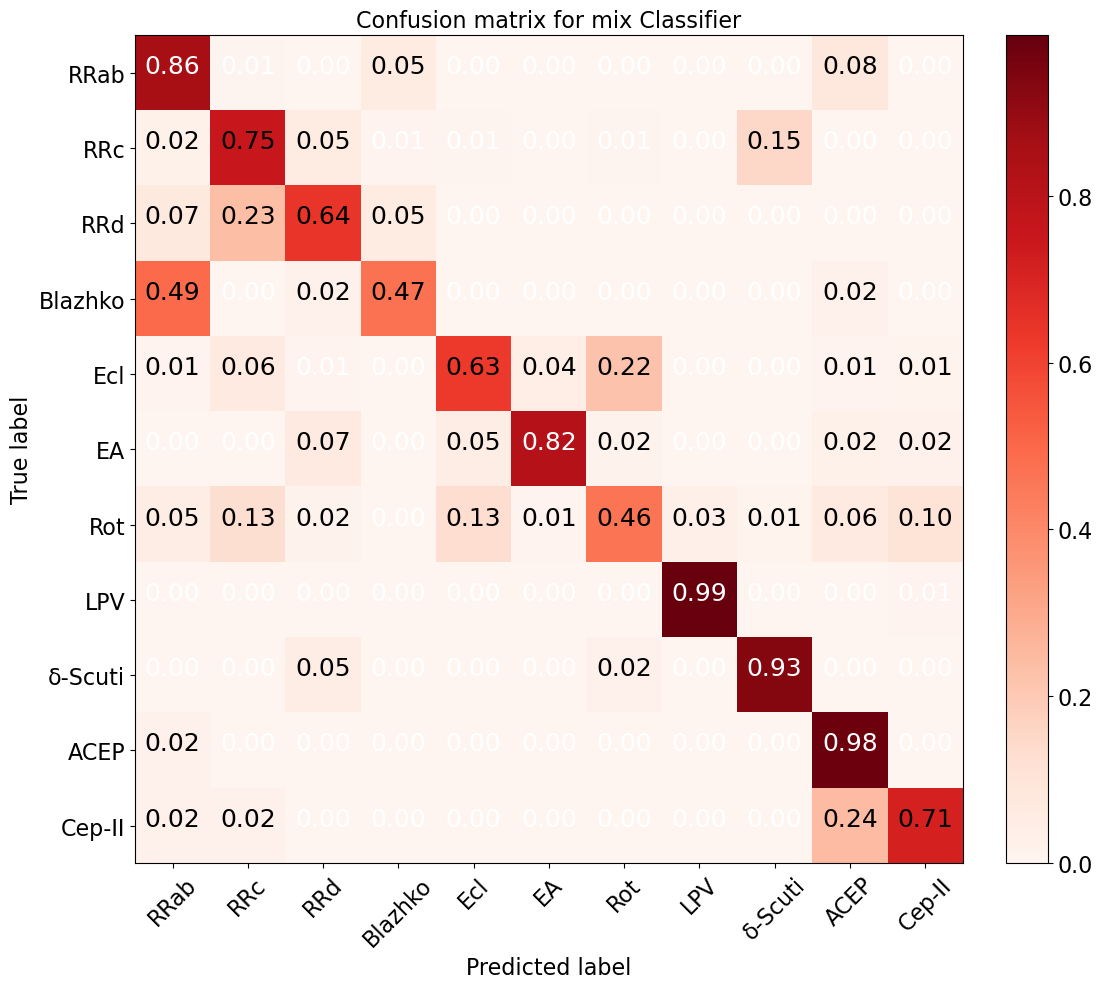

In [44]:
loaded_model = keras.models.load_model('models/xnn_with_feature_test/model_45', compile=False)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from util import generate_batch

test_gen = generate_batch(X_sequence=X_sequence_test_trimed,X_image=X_image_test,X_feature=X_feature_test, Y=Y_test, batch_size=128)      
y_label = Y_test

y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
    y_predict = np.concatenate([y_predict, 
            np.argmax(loaded_model.predict({
                                            'sequence':x_sequence, 
                                            'image':x_image,
                                            'feature':x_feature}), axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, 
                        # labels=[], 
                        # labels用于交换顺序
                        normalize='true')

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']
from util import cm_plot
plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=11,
                    cmap=plt.cm.Blues)

